###

## 1 .Loading Dataset,

In [1]:
from torch.nn import functional as F
import torch
from transformers import AutoModelForCausalLM,  GPT2Tokenizer
from trl import DPOTrainer, DPOConfig
from datasets import load_dataset, Dataset
from huggingface_hub import login
import pandas as pd
from sklearn.metrics import accuracy_score
import numpy as np
import logging
from huggingface_hub import notebook_login, whoami
import wandb

In [2]:
# Initialize logging for monitoring
logging.basicConfig(level=logging.INFO)

In [3]:
# Initialize wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mirali111 (mirali111-asian-institue-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
notebook_login()

# Full Code with experimentation

In [5]:
# Load dataset
logging.info("Loading dataset...")
dataset = load_dataset("Anthropic/hh-rlhf", split="train[:1000]")

# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained("gpt2").cuda()

# Preprocess dataset
def preprocess_function(examples):
    chosen = tokenizer(examples['chosen'], truncation=True, padding='max_length', max_length=512)
    rejected = tokenizer(examples['rejected'], truncation=True, padding='max_length', max_length=512)
    return {
        'chosen_input_ids': chosen['input_ids'],
        'rejected_input_ids': rejected['input_ids'],
        'chosen_attention_mask': chosen['attention_mask'],
        'rejected_attention_mask': rejected['attention_mask']}

processed_dataset  = dataset.map(preprocess_function, batched=True)

train_eval_dataset = processed_dataset.train_test_split(test_size=0.2)
train_dataset = train_eval_dataset["train"]
eval_dataset = train_eval_dataset["test"]

# Experimenting with different hyperparameters
hyperparams = [
    {"learning_rate": 5e-5, "batch_size": 3, "weight_decay": 0.01},
    {"learning_rate": 1e-4, "batch_size": 3, "weight_decay": 0.01},
    {"learning_rate": 2e-5, "batch_size": 4, "weight_decay": 0.005}]

best_model = None
best_loss = float("inf")

results = []

for params in hyperparams:
    
    run = wandb.init(
        project="dpo-gpt2-tuning",
        config={
            "model": "gpt2",
            "dataset": "Anthropic/hh-rlhf",
            "learning_rate": params["learning_rate"],
            "batch_size": params["batch_size"],
            "weight_decay": params["weight_decay"],
            "warmup_ratio": 0.1,
            "epochs": 2},
        name=f"lr-{params['learning_rate']}_bs-{params['batch_size']}_ep-1",
        reinit=True)
    
    logging.info(f"Training with {params}")
    training_args = DPOConfig(
        output_dir="./results",
        do_eval=True,
        eval_strategy="epoch",  
        warmup_ratio=0.1,
        save_strategy="epoch", 
        logging_strategy="epoch",
        logging_steps=1,
        per_device_train_batch_size=params["batch_size"],
        per_device_eval_batch_size=params["batch_size"],  
        num_train_epochs=2,  
        learning_rate=params["learning_rate"],
        weight_decay=params["weight_decay"],
        logging_dir="./logs",
        fp16=True,
        report_to="wandb")

    # Define custom callback to log more metrics to W&B
    class WandbCallback:
        def on_log(self, args, state, control, logs=None, **kwargs):
            if logs:
                wandb.log(logs)
                                
    trainer = DPOTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset, 
        processing_class=tokenizer,)
    
    trainer.train()
    eval_results = trainer.evaluate()
    eval_loss = trainer.evaluate()["eval_loss"]
    logging.info(f"Eval Loss: {eval_loss}")
    
    # Log evaluation results to wandb
    wandb.log({"final_eval_loss": eval_loss})
    
    if eval_loss < best_loss:
        best_loss = eval_loss
        best_model = model
        
        # Save best model metadata
        run.summary["best_model"] = True
        
    # Store results for comparison
    results.append({
        "learning_rate": params["learning_rate"],
        "batch_size": params["batch_size"],
        "epochs": 2,
        "weight_decay" : params["weight_decay"],
        "eval_loss": eval_loss,
        "run_id": run.id
    })
    
# Log a summary table of all runs
summary_table = wandb.Table(
    columns=["Run ID", "Learning Rate", "Batch Size", "Epochs", "Eval Loss", "Weight Decay", "Is Best"])

for result in results:
    summary_table.add_data(
        result["run_id"],
        result["learning_rate"],
        result["batch_size"],
        result["epochs"],
        result["eval_loss"],
        result["weight_decay"],
        result["eval_loss"] == best_loss)
    
# Final wandb run to log the summary table
final_run = wandb.init(project="dpo-gpt2-tuning", name="hyperparameter-summary")
wandb.log({"results_summary": summary_table})

# Save and push best model to Hugging Face Hub
best_model_path = f"./best_model/eval_loss-{best_loss}"
best_model.save_pretrained(best_model_path)
tokenizer.save_pretrained(best_model_path)

# Save and push best model to Hugging Face Hub
best_model.push_to_hub("mirali111/dpo-gpt2-model")
tokenizer.push_to_hub("mirali111/dpo-gpt2-model")

# Now finish wandb
wandb.finish()

INFO:root:Loading dataset...


INFO:root:Training with {'learning_rate': 5e-05, 'batch_size': 3, 'weight_decay': 0.01}


Extracting prompt in train dataset:   0%|          | 0/800 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/800 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/800 [00:00<?, ? examples/s]

Extracting prompt in eval dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
c:\Users\Mir Ali\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\integrations\sdpa_attention.py:53: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
1,0.787100,0.706522,-1.121301,-1.973873,0.686567,0.852573,-126.268555,-171.166153,-114.789146,-113.331436
2,0.258600,1.058684,-3.213047,-4.710779,0.641791,1.497732,-147.186020,-198.535187,-149.755096,-148.591812


INFO:root:Eval Loss: 1.0586844682693481


eval/logits/chosen,█▁▁▁
eval/logits/rejected,█▁▁▁
eval/logps/chosen,█▁▁▁
eval/logps/rejected,█▁▁▁
eval/loss,▁███
eval/rewards/accuracies,█▁▁▁
eval/rewards/chosen,█▁▁▁
eval/rewards/margins,▁███
eval/rewards/rejected,█▁▁▁
eval/runtime,▁██▆
eval/samples_per_second,█▁▁▂


INFO:root:Training with {'learning_rate': 0.0001, 'batch_size': 3, 'weight_decay': 0.01}


Epoch,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
1,1.404800,1.963546,-8.770614,-11.583295,0.626866,2.812682,-234.892136,-314.368134,-106.181564,-107.275963
2,0.225600,2.168074,-8.890997,-12.068528,0.616915,3.177531,-236.095993,-319.220490,-94.247330,-95.396240


INFO:root:Eval Loss: 2.168074131011963


eval/logits/chosen,▁███
eval/logits/rejected,▁███
eval/logps/chosen,█▁▁▁
eval/logps/rejected,█▁▁▁
eval/loss,▁███
eval/rewards/accuracies,█▁▁▁
eval/rewards/chosen,█▁▁▁
eval/rewards/margins,▁███
eval/rewards/rejected,█▁▁▁
eval/runtime,▅█▇▁
eval/samples_per_second,▄▁▂█


INFO:root:Training with {'learning_rate': 2e-05, 'batch_size': 4, 'weight_decay': 0.005}


Epoch,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
1,0.239000,1.387028,-4.881563,-6.466868,0.600000,1.585306,-284.344757,-383.350128,-83.633575,-85.980957
2,0.021900,1.541081,-5.837779,-7.798605,0.635000,1.960826,-293.906921,-396.667450,-81.052391,-83.480858


INFO:root:Eval Loss: 1.5410810708999634


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

c:\Users\Mir Ali\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Mir Ali\.cache\huggingface\hub\models--mirali111--dpo-gpt2-model. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
No files have been modified since last commit. Skipping to prevent empty commit.


eval/logits/chosen,▁███
eval/logits/rejected,▁███
eval/logps/chosen,█▁▁▁
eval/logps/rejected,█▁▁▁
eval/loss,▁███
eval/rewards/accuracies,▁███
eval/rewards/chosen,█▁▁▁
eval/rewards/margins,▁███
eval/rewards/rejected,█▁▁▁
eval/runtime,▇▅█▁
eval/samples_per_second,▃▄▁█


In [8]:
# Convert results to a pandas DataFrame
results_df = pd.DataFrame(results)

# Print the results DataFrame
results_df

,learning_rate,batch_size,epochs,weight_decay,eval_loss,run_id
0,0.00005,3,2,0.010,1.058684,bg21g3i5
1,0.00010,3,2,0.010,2.168074,2cej41hw
2,0.00002,4,2,0.005,1.541081,40506liv


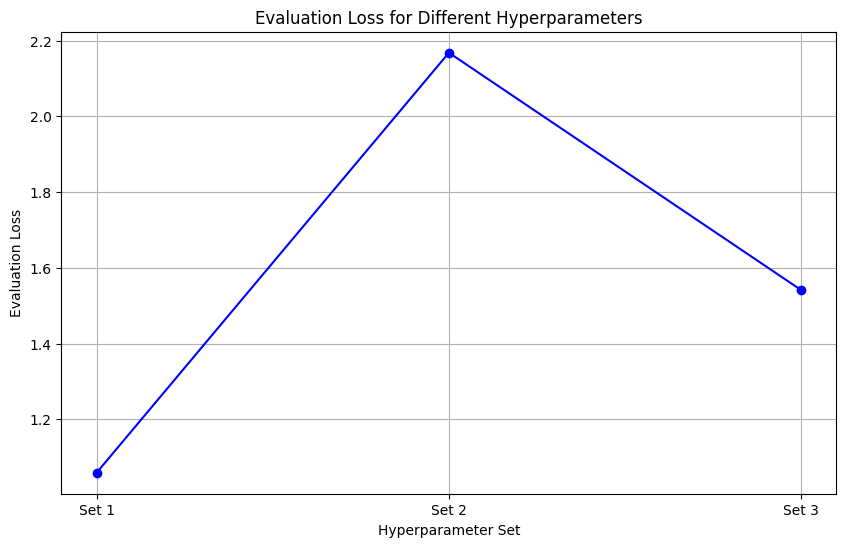

In [9]:
import matplotlib.pyplot as plt
# Plotting the evaluation loss for different hyperparameters
plt.figure(figsize=(10, 6))
plt.plot(results_df.index, results_df['eval_loss'], marker='o', linestyle='-', color='b')
plt.title('Evaluation Loss for Different Hyperparameters')
plt.xlabel('Hyperparameter Set')
plt.ylabel('Evaluation Loss')
plt.xticks(results_df.index, [f"Set {i+1}" for i in results_df.index])
plt.grid(True)
plt.show()